# Simple OLS

## Import

In [1]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.stats as ss

## Data Generation

In [2]:
# Data Generation
np.random.seed(42) # Fix Random
x = np.arange(1, 5, 0.1)
eps = np.random.randn(len(x))
y = 2 * x + 3 + eps

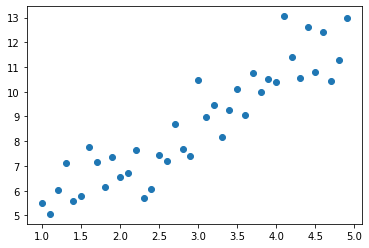

In [3]:
plt.scatter(x, y)

In [4]:
# Data to Matrix
X = np.matrix(x).T
X = sm.add_constant(X)
Y = np.matrix(y).T

In [5]:
X.shape

(40, 2)

In [6]:
Y.shape

(40, 1)

## Estimate Procedure

In [7]:
def find_beta_hat(X, Y):
    #return np.linalg.inv(X.T * X) * X.T * Y
    if np.linalg.det(X.T * X) == 0:
        print("Singular!")
    return np.linalg.pinv(X) * Y

In [8]:
beta = find_beta_hat(X, Y)

In [9]:
beta

matrix([[3.3835158 ],
        [1.79588046]])

In [10]:
def find_y_hat(X, beta):
    return X * beta

In [11]:
Y_hat = find_y_hat(X, beta)

In [12]:
Y_hat.shape

(40, 1)

In [13]:
y_hat = np.asarray(Y_hat).ravel()
y_hat

array([ 5.17939626,  5.35898431,  5.53857236,  5.7181604 ,  5.89774845,
        6.07733649,  6.25692454,  6.43651259,  6.61610063,  6.79568868,
        6.97527672,  7.15486477,  7.33445282,  7.51404086,  7.69362891,
        7.87321695,  8.052805  ,  8.23239305,  8.41198109,  8.59156914,
        8.77115718,  8.95074523,  9.13033328,  9.30992132,  9.48950937,
        9.66909742,  9.84868546, 10.02827351, 10.20786155, 10.3874496 ,
       10.56703765, 10.74662569, 10.92621374, 11.10580178, 11.28538983,
       11.46497788, 11.64456592, 11.82415397, 12.00374201, 12.18333006])

In [14]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

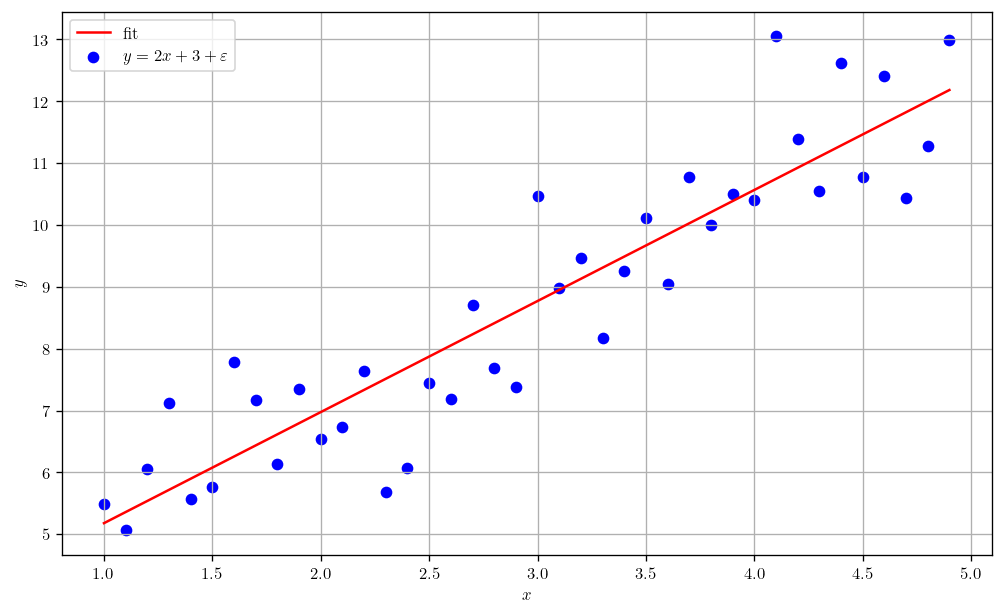

In [15]:
plt.figure(figsize=(10, 6), dpi=120)
plt.scatter(x, y, color='b', label=r"$y = 2x + 3 +\varepsilon$")
plt.plot(x, y_hat, color='r', label=r"fit")
plt.legend()
plt.grid()
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()

## t-test from scratch

$$RSS = \sum_{i=1}^N (y_i - \hat{y}_i)^2$$
$$\hat{\sigma}^2 = \sum_{i=1}^N (y_i - \hat{y}_i)^2 / (N-p-1)$$
$$t_j = \hat{\beta}_j / (\hat{\sigma} \sqrt{v_j}),\quad v_j = (X^TX)^{-1}_{jj}$$

In [16]:
def calc_rss(y, y_hat):
    return np.sum((y - y_hat) ** 2)

In [17]:
def find_sigma_hat(y, y_hat, p):
    return calc_rss(y, y_hat) / (len(y) - p -1)

In [18]:
def calc_t_score(beta, X, sigma_square):
    v = np.sqrt(np.diag(np.linalg.inv(X.T * X)))
    return (beta / v) / np.sqrt(sigma_square)

In [19]:
def calc_p_value(d, z):           # d: Distribution
    if z >= 0:
        return (1 - d.cdf(z)) * 2 # cdf(t) = p(x < t)
    else:
        return d.cdf(z) * 2

## Implementation with OOP

### What is OOP?

In [20]:
# OOP : Object-Oriented-Programming

class Person:
    def __init__(self, name, age):
        self.name = name
        self.age = age
        
    def double_age(self):
        return self.age * 2

In [21]:
chulsoo = Person("철수", 20)

In [22]:
chulsoo.name

'철수'

In [23]:
chulsoo.double_age()

40

In [24]:
# Inheritance (상속)
class Animal:
    def bark(self):
        print("I'm animal!")
        
class Dog(Animal):
    def bark(self):
        print("I'm dog!")
        
class Bird(Animal):
    def bark(self):
        print("I'm bird!")
        
class Cat(Animal):
    def bark(self):
        super().bark()

In [25]:
a = Animal()
b = Dog()
c = Bird()
d = Cat()

a.bark()
b.bark()
c.bark()
d.bark()

I'm animal!
I'm dog!
I'm bird!
I'm animal!


In [26]:
class OLSEstimator:
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        self.y = np.asarray(self.Y).ravel()
        self.N = Y.shape[0]
        self.p = X.shape[1] - 1
        
    def estimate(self):
        self.beta_hat = find_beta_hat(self.X, self.Y)
        self.Y_hat = find_y_hat(self.X, self.beta_hat)
        self.y_hat = np.asarray(self.Y_hat).ravel()
        print("Estimate Success!")
        
    def test(self):
        self.rss = calc_rss(self.y, self.y_hat)
        self.sigma_hat = find_sigma_hat(self.y, self.y_hat, self.p)
        self.t_score = calc_t_score(np.asarray(self.beta_hat).ravel(), self.X, self.sigma_hat)
        
        t_dist = ss.t(df=self.N-self.p-1)
        
        p_fun = lambda t: calc_p_value(t_dist, t)
        p_vec = np.vectorize(p_fun)
        
        self.p_value = p_vec(self.t_score)
        
        print("Test Success!")
        
    def f_test(self, other): # self.f_test(other)
        if self.p >= other.p:
            rss_0 = other.rss
            rss_1 = self.rss
            p_0 = other.p
            p_1 = self.p
            N = self.N
            
            f_score = ((rss_0 - rss_1) / (p_1 - p_0)) / (rss_1 / (N - p_1 - 1))
            
            f_dist = ss.f(p_1-p_0, N - p_1 - 1)
            
            p_value = calc_p_value(f_dist, f_score)
            
            return (f_score, p_value)
        else:
            return other.f_test(self)
        
    def summary(self):
        print("N: ", self.N)
        print("p: ", self.p)
        print("beta: ", np.asarray(self.beta_hat).ravel())
        print("rss: ", self.rss)
        print("t_score: ", self.t_score)
        print("p_value: ", self.p_value)
    
    def plot(self):
        x = np.asarray(self.X[:, 1]).ravel()
        y = self.y
        y_hat = self.y_hat
        
        plt.figure(figsize=(10, 6), dpi=120)
        plt.scatter(x, y, label="data")
        plt.plot(x, y_hat, color='r', label="fit")
        plt.legend()
        plt.grid()
        plt.show()
    

### Vectorize?

In [27]:
def f(x):
    if x >= 0:
        return x**2
    else:
        return x

In [28]:
f_vec = np.vectorize(f)

In [29]:
f_vec(x)

array([ 1.  ,  1.21,  1.44,  1.69,  1.96,  2.25,  2.56,  2.89,  3.24,
        3.61,  4.  ,  4.41,  4.84,  5.29,  5.76,  6.25,  6.76,  7.29,
        7.84,  8.41,  9.  ,  9.61, 10.24, 10.89, 11.56, 12.25, 12.96,
       13.69, 14.44, 15.21, 16.  , 16.81, 17.64, 18.49, 19.36, 20.25,
       21.16, 22.09, 23.04, 24.01])

### OLS with OLSEstimator

In [30]:
ols = OLSEstimator(X, Y)

In [31]:
ols.estimate()
ols.test()

Estimate Success!
Test Success!


In [32]:
ols.summary()

N:  40
p:  1
beta:  [3.3835158  1.79588046]
rss:  33.185220129278996
t_score:  [ 8.34435115 14.03009064]
p_value:  [4.04864142e-10 0.00000000e+00]


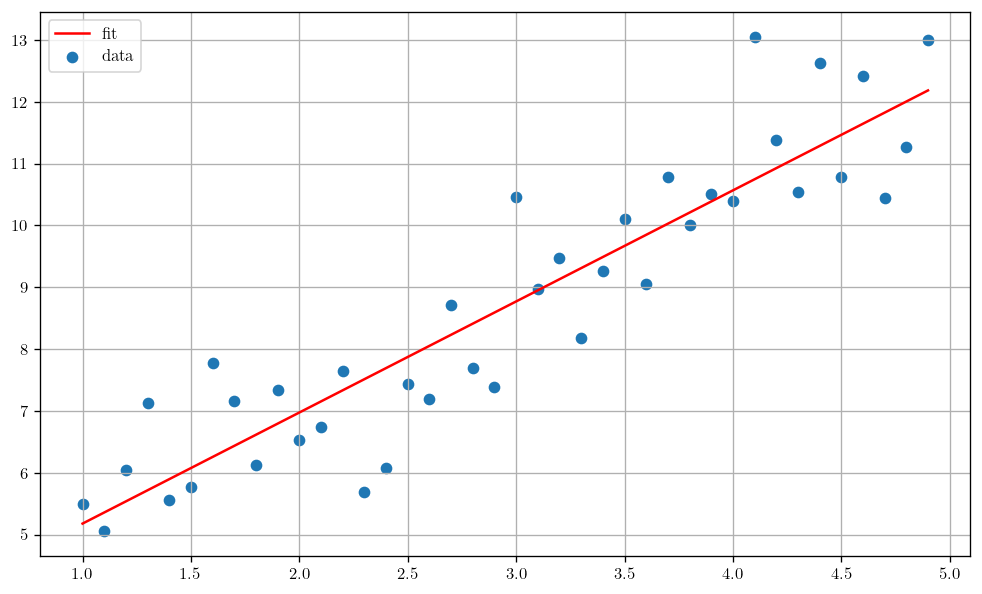

In [33]:
ols.plot()

### F-test between two models

$$y = 2x^2 + 3x + 5 + \varepsilon$$

* First model
$$y = \beta_0 + \beta_1 x$$

* Second model
$$y = \beta_0 + \beta_1 x + \beta_2 x^2$$

In [34]:
x1 = np.arange(1, 5, 0.1)
x2 = x1 ** 2
y = -2 * x2 + 3 * x1 + 5 + np.random.randn(len(x1))

X1 = np.matrix(x1).T
X1 = sm.add_constant(X1)
Y = np.matrix(y).T

X2 = np.matrix(np.column_stack((x1, x2)))
X2 = sm.add_constant(X2)

In [35]:
ols_1 = OLSEstimator(X1, Y)
ols_2 = OLSEstimator(X2, Y)

In [36]:
ols_1.estimate(); ols_1.test()

Estimate Success!
Test Success!


In [37]:
ols_2.estimate(); ols_2.test()

Estimate Success!
Test Success!


In [38]:
ols_1.summary()

N:  40
p:  1
beta:  [19.6655516 -8.7846085]
rss:  292.551593331763
t_score:  [ 16.33434082 -23.11407829]
p_value:  [0.00000000e+00 5.55837384e-24]


In [39]:
ols_2.summary()

N:  40
p:  2
beta:  [ 3.96974824  3.78055294 -2.12968838]
rss:  35.33382890000898
t_score:  [  3.79459818   4.864132   -16.4117915 ]
p_value:  [5.31098218e-04 2.14491253e-05 1.43919948e-18]


In [40]:
ols_1.f_test(ols_2)

(269.346900130953, 2.220446049250313e-16)

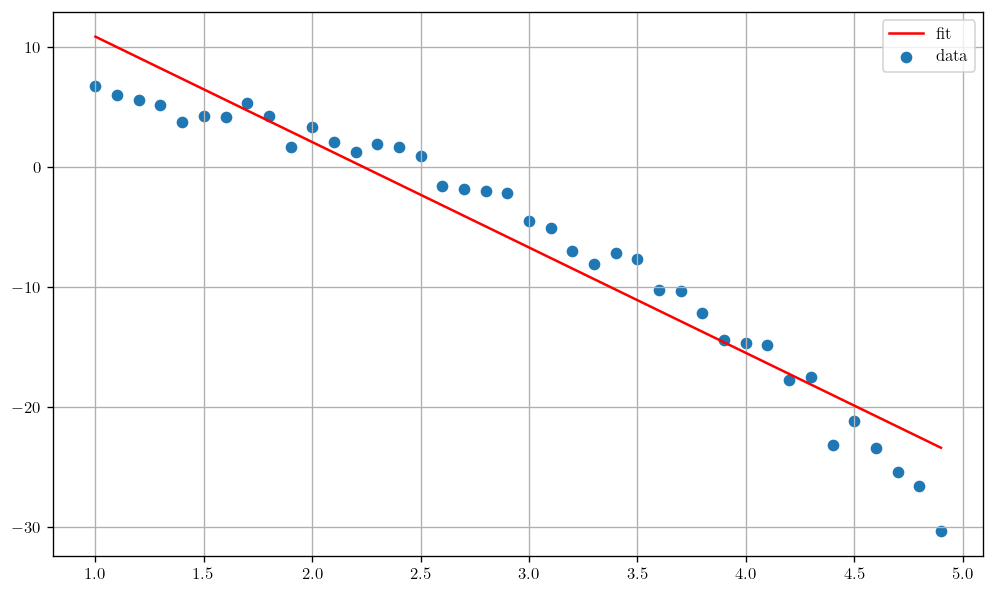

In [41]:
ols_1.plot()

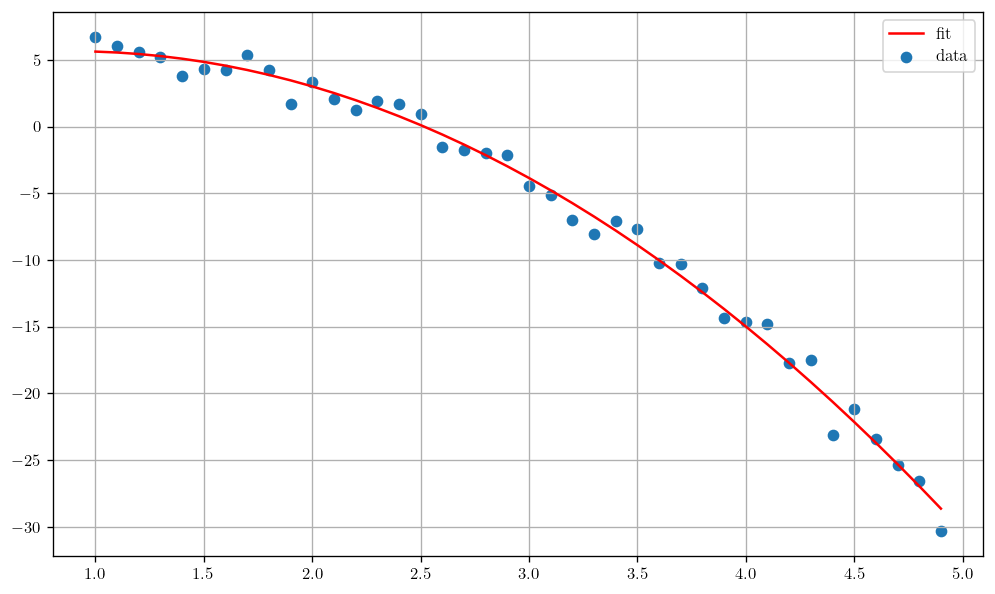

In [42]:
ols_2.plot()

## t-test from statsmodels

In [43]:
model = sm.OLS(Y, X).fit()

In [44]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     534.3
Date:                Mon, 03 May 2021   Prob (F-statistic):           5.56e-24
Time:                        20:57:50   Log-Likelihood:                -96.553
No. Observations:                  40   AIC:                             197.1
Df Residuals:                      38   BIC:                             200.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.6656      1.204     16.334      0.000      17.228      22.103
x1            -8.7846      0.380    -23.114      0.000      -9.554      -8.015
==============================================================================
Omnibus:                        3.881   Durbin-Watson:                   0.289
Prob(Omnibus):                  0.144   Jarque-Bera (JB):                3.451
Skew:                          -0.639   Prob(JB):                        0.178
Kurtosis:                       2.339   Cond. No.                         9.45
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [45]:
y_hat = model.predict()

In [46]:
y_hat

array([ 10.8809431 ,  10.00248225,   9.1240214 ,   8.24556055,
         7.3670997 ,   6.48863885,   5.610178  ,   4.73171715,
         3.85325631,   2.97479546,   2.09633461,   1.21787376,
         0.33941291,  -0.53904794,  -1.41750879,  -2.29596964,
        -3.17443049,  -4.05289134,  -4.93135219,  -5.80981304,
        -6.68827389,  -7.56673474,  -8.44519559,  -9.32365644,
       -10.20211729, -11.08057814, -11.95903899, -12.83749984,
       -13.71596069, -14.59442154, -15.47288239, -16.35134323,
       -17.22980408, -18.10826493, -18.98672578, -19.86518663,
       -20.74364748, -21.62210833, -22.50056918, -23.37903003])

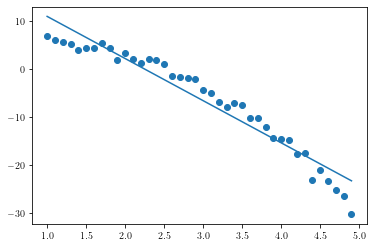

In [47]:
plt.scatter(x,y)
plt.plot(x, y_hat)

In [48]:
model_1 = sm.OLS(Y, X1).fit()

In [49]:
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     534.3
Date:                Mon, 03 May 2021   Prob (F-statistic):           5.56e-24
Time:                        20:57:50   Log-Likelihood:                -96.553
No. Observations:                  40   AIC:                             197.1
Df Residuals:                      38   BIC:                             200.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.6656      1.204     16.334      0.000      17.228      22.103
x1            -8.7846      0.380    -23.114      0.000      -9.554      -8.015
==============================================================================
Omnibus:                        3.881   Durbin-Watson:                   0.289
Prob(Omnibus):                  0.144   Jarque-Bera (JB):                3.451
Skew:                          -0.639   Prob(JB):                        0.178
Kurtosis:                       2.339   Cond. No.                         9.45
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [50]:
model_2 = sm.OLS(Y, X2).fit()

In [51]:
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     2288.
Date:                Mon, 03 May 2021   Prob (F-statistic):           1.69e-39
Time:                        20:57:50   Log-Likelihood:                -54.277
No. Observations:                  40   AIC:                             114.6
Df Residuals:                      37   BIC:                             119.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.9697      1.046      3.795      0.001       1.850       6.089
x1             3.7806      0.777      4.864      0.000       2.206       5.355
x2            -2.1297      0.130    -16.412      0.000      -2.393      -1.867
==============================================================================
Omnibus:                        2.201   Durbin-Watson:                   2.112
Prob(Omnibus):                  0.333   Jarque-Bera (JB):                1.823
Skew:                          -0.518   Prob(JB):                        0.402
Kurtosis:                       2.859   Cond. No.                         106.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""